In [113]:
from sunpy.time import parse_time, TimeRange
from flarelist_utils import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates

In [2]:
# directory where .txt files are saved to
savedir = "/Users/laurahayes/ml_project_flares/flare_analysis/goes_flare_list/goes_files/"

# final columns of interest to merge lists on
final_columns = ["date", "start_time", "max_time", "end_time",
                 "goes_class", "goes_class_ind", "integrated_flux", "noaa_ar", "goes_sat"]


In [4]:
def merge_ngdc(tstart, tend):
    """
    Read and merge the NGDC yearly files into a single pandas DataFrame

    Parameters
    ----------
    tstart : `str` 
        start time (yearly date)
    tend : `str`
        end time (yearly date)

    Returns
    -------
    df_flares : pd.DataFrame merged between tstart and tend with `final_columns` columns.

    """
    files = get_ngdc_reports(TimeRange(tstart, tend), savedir=savedir)
    files.sort()

    df_flares = read_ngdc_goes_reports(files[0])
    for f in files[1:]:
        df = read_ngdc_goes_reports(f)
        df_flares = df_flares.append(df)

    df_flares.reset_index(inplace=True)
    df_flares["noaa_ar"] = df_flares["noaa_ar"].replace(["\n",""],  "     ")
    return df_flares[final_columns]


def merge_swpc(tstart, tend):
    """
    Read and merge the daily SWPC report files into a single pandas DataFrame

    Parameters
    ----------
    tstart : `str` 
        start time 
    tend : `str`
        end time 

    Returns
    -------
    df_flares : pd.DataFrame merged between `tstart` and `tend` with `final_columns` columns.
    """
    files = get_swpc_reports(TimeRange(tstart, tend), savedir=savedir)
    files.sort()

    df_flares = read_swpc_reports(files[0])
    for f in files[1:]:
        df = read_swpc_reports(f)
        df_flares = df_flares.append(df)
    df_flares.reset_index(inplace=True)
    return df_flares[final_columns]



## Test flarelists when data is available for overlapping times
Lets test for 2016

In [96]:
test_ngdc = merge_ngdc("2016-01-01", "2016-12-31")
test_swpc = merge_swpc("2016-01-01", "2016-12-31")

In [94]:
test_ngdc.head()

,date,start_time,max_time,end_time,goes_class,goes_class_ind,integrated_flux,noaa_ar,goes_sat,full_date,datetime
0,20160101,0438,0441,0451,B6.2,B,3.6E-04,,G15,20160101 0438,2016-01-01 04:38:00
1,20160101,0633,0638,0643,C2.3,C,8.4E-04,12473,G15,20160101 0633,2016-01-01 06:33:00
2,20160101,0936,0948,0956,C2.4,C,2.0E-03,12473,G15,20160101 0936,2016-01-01 09:36:00
3,20160101,1730,1736,1743,B8.4,B,4.7E-04,,G15,20160101 1730,2016-01-01 17:30:00
4,20160101,2018,2021,2023,B5.4,B,8.8E-05,,G15,20160101 2018,2016-01-01 20:18:00


In [39]:
print("NGDC:", len(test_ngdc), "SWPC:", len(test_swpc), "difference:", np.abs(len(test_ngdc)-len(test_swpc)))

NGDC: 1194 SWPC: 1260 difference: 66


In [38]:
test_swpc["goes_class_ind"].unique()

array(['B', 'C', 'M'], dtype=object)

In [37]:
print("M flares for SWPC: {:d} and NGDC: {:d}".format(np.sum(test_swpc["goes_class_ind"].isin(["M"])), 
                                                         np.sum(test_ngdc["goes_class_ind"].isin(["M"]))))

print("C flares for SWPC: {:d} and NGDC: {:d}, difference = {:d}".format(np.sum(test_swpc["goes_class_ind"].isin(["C"])), 
                                  np.sum(test_ngdc["goes_class_ind"].isin(["C"])),
                                  np.abs(np.sum(test_ngdc["goes_class_ind"].isin(["C"]))- np.sum(test_swpc["goes_class_ind"].isin(["C"]))))                                                             )
                                                             
print("B flares for SWPC: {:d} and NGDC: {:d}, difference = {:d}".format(np.sum(test_swpc["goes_class_ind"].isin(["B"])), 
                    np.sum(test_ngdc["goes_class_ind"].isin(["B"])), 
                    np.abs(np.sum(test_ngdc["goes_class_ind"].isin(["B"]))- np.sum(test_swpc["goes_class_ind"].isin(["B"]))))                                                             )




M flares for SWPC: 16 and NGDC: 16
C flares for SWPC: 321 and NGDC: 302, difference = 19
B flares for SWPC: 923 and NGDC: 876, difference = 47


In [98]:
test_swpc["datetime_start"] = pd.to_datetime(test_swpc.date + test_swpc.start_time, format="%Y%m%d%H%M")
test_ngdc["datetime_start"] = pd.to_datetime(test_ngdc.date + test_ngdc.start_time, format="%Y%m%d%H%M")

test_swpc["datetime_peak"] = pd.to_datetime(test_swpc.date + test_swpc.max_time, format="%Y%m%d%H%M")
test_ngdc["datetime_peak"] = pd.to_datetime(test_ngdc.date + test_ngdc.max_time, format="%Y%m%d%H%M")

test_swpc["datetime_end"] = pd.to_datetime(test_swpc.date + test_swpc.end_time, format="%Y%m%d%H%M")
test_ngdc["datetime_end"] = pd.to_datetime(test_ngdc.date + test_ngdc.end_time, format="%Y%m%d%H%M")

/Users/laurahayes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


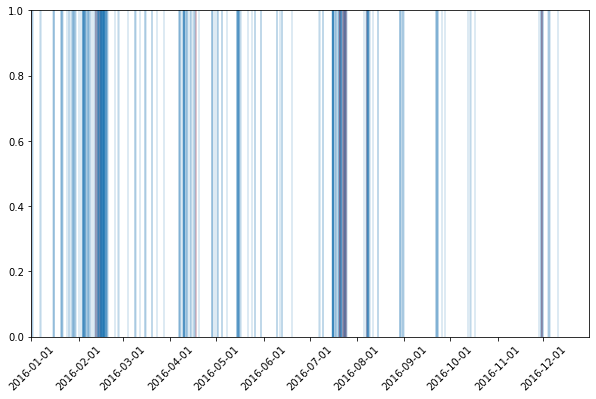

In [119]:
test_swpc_c = test_swpc[test_swpc["goes_class_ind"].isin(["X", "M", "C"])]

def map_cols(x):
    if x == "X":
        return "r"
    elif x == "M":
        return "r"
    elif x == "C":
        return "tab:blue"
    
    else:
        return
test_swpc_c["colors"] = test_swpc_c["goes_class_ind"].map(map_cols)
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(test_swpc_c)):
    plt.axvline(test_swpc_c["datetime_peak"].iloc[i], lw=0.3, color=test_swpc_c["colors"].iloc[i])
plt.xlim(parse_time("2016-01-01").datetime, parse_time("2016-12-31").datetime)
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_tick_params(rotation=45)

In [123]:
test_swpc_c["datetime_start"].iloc[0]

Timestamp('2016-01-01 06:33:00')

In [133]:
float(test_swpc_c["goes_class"].iloc[0][1:])

2.3

In [197]:
len(test_swpc_c)

337

In [134]:
def get_goes_class(x):
    if x[0]=="C":
        return float(x[1:])*1e-6
    elif x[0] == "M":
        return float(x[1:])*(1e-5)
    elif x[0] == "X":
        return float(x[1:])*(1e-4)
    else:
        return

In [136]:
test_swpc_c["goes_val"] = test_swpc_c["goes_class"].map(get_goes_class)

/Users/laurahayes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [140]:
test_swpc_c["goes_val"].unique()

array([2.3e-06, 2.4e-06, 2.7e-06, 2.3e-05, 1.8e-06, 1.0e-06, 2.8e-06,
       1.7e-06, 1.1e-06, 1.3e-06, 2.9e-06, 1.4e-06, 5.3e-06, 9.6e-06,
       3.3e-06, 2.0e-06, 3.5e-06, 1.2e-06, 1.6e-06, 2.1e-06, 3.6e-06,
       5.1e-06, 3.0e-06, 1.5e-06, 2.6e-06, 8.9e-06, 1.0e-05, 6.8e-06,
       1.8e-05, 2.5e-06, 3.4e-06, 6.9e-06, 3.9e-06, 5.2e-06, 1.1e-05,
       4.2e-06, 2.2e-06, 4.1e-06, 1.9e-06, 9.4e-06, 7.4e-06, 4.6e-06,
       7.2e-06, 3.7e-06, 5.8e-06, 6.7e-05, 4.8e-06, 4.9e-06, 3.2e-06,
       6.5e-06, 8.6e-06, 6.6e-06, 4.4e-06, 1.2e-05, 9.1e-06, 5.0e-05,
       7.6e-05, 5.5e-05, 2.0e-05, 1.9e-05, 1.3e-05, 8.5e-06, 5.6e-06,
       3.1e-06, 7.5e-06, 6.0e-06, 4.0e-06])

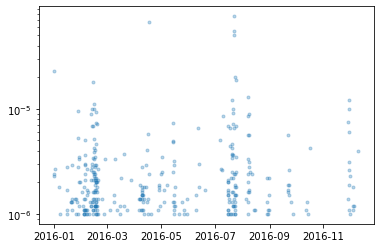

In [169]:
plt.plot(test_swpc_c["datetime_peak"], test_swpc_c["goes_val"], marker=".", ls="", alpha=0.3)
plt.yscale("log")

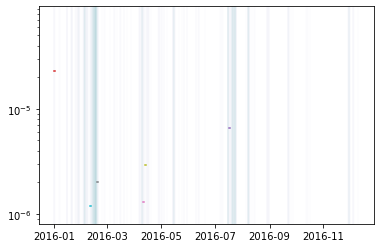

In [164]:
%matplotlib inline
for i in range(len(test_swpc_c)):
    plt.plot([test_swpc_c["datetime_start"].iloc[i], test_swpc_c["datetime_end"].iloc[i]], 
             [test_swpc_c["goes_val"].iloc[i], test_swpc_c["goes_val"].iloc[i]])
    plt.axvline(test_swpc_c["datetime_peak"].iloc[i], alpha=0.01)
plt.yscale("log")

In [157]:
test_swpc_c = test_swpc_c.sort_values(by="datetime_start")

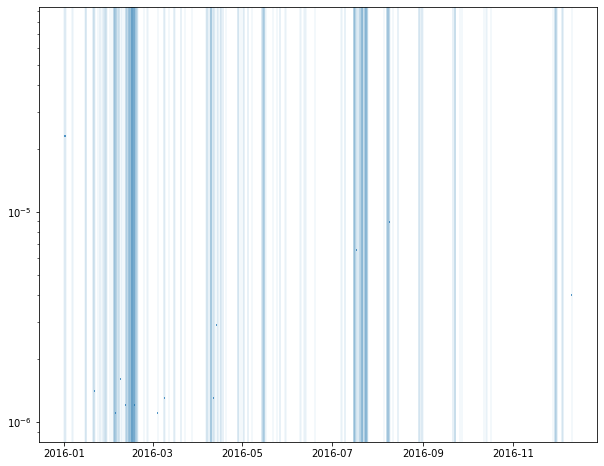

In [149]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(test_swpc_c)):
    try:
        plt.hlines(y = test_swpc_c["goes_val"].iloc[i], 
                   xmin = test_swpc_c["datetime_start"].iloc[i], 
                   xmax = test_swpc_c["datetime_end"].iloc[i])
        plt.axvline(test_swpc_c["datetime_peak"].iloc[i], lw=0.1)
    except:
        print(test_swpc_c.iloc[i])
plt.yscale("log")

In [55]:
(test_swpc["datetime"][1] - test_swpc["datetime"][0]).total_seconds()

6900.0

In [71]:
dtt = [d.total_seconds() for d in test_swpc["datetime"] - test_swpc["datetime"].shift()]
print("swpc: ", np.nanmin(dtt))

swpc:  60.0


In [72]:
dtt = [d.total_seconds() for d in test_ngdc["datetime"] - test_ngdc["datetime"].shift()]
print("swpc: ", np.nanmin(dtt))

swpc:  60.0


In [73]:
pd.merge(test_swpc, test_ngdc, on="full_date")

,date_x,start_time_x,max_time_x,end_time_x,goes_class_x,goes_class_ind_x,integrated_flux_x,noaa_ar_x,goes_sat_x,full_date,...,date_y,start_time_y,max_time_y,end_time_y,goes_class_y,goes_class_ind_y,integrated_flux_y,noaa_ar_y,goes_sat_y,datetime_y
0,20160101,0438,0441,0451,B6.2,B,3.6E-04,12477,G15,20160101 0438,...,20160101,0438,0441,0451,B6.2,B,3.6E-04,,G15,2016-01-01 04:38:00
1,20160101,0633,0638,0643,C2.3,C,8.4E-04,12473,G15,20160101 0633,...,20160101,0633,0638,0643,C2.3,C,8.4E-04,12473,G15,2016-01-01 06:33:00
2,20160101,0936,0948,0956,C2.4,C,2.0E-03,12473,G15,20160101 0936,...,20160101,0936,0948,0956,C2.4,C,2.0E-03,12473,G15,2016-01-01 09:36:00
3,20160101,1730,1736,1743,B8.4,B,4.7E-04,12473,G15,20160101 1730,...,20160101,1730,1736,1743,B8.4,B,4.7E-04,,G15,2016-01-01 17:30:00
4,20160101,2018,2021,2023,B5.5,B,8.8E-05,12473,G15,20160101 2018,...,20160101,2018,2021,2023,B5.4,B,8.8E-05,,G15,2016-01-01 20:18:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,20161229,2011,2015,2020,B1.3,B,4.9E-05,12619,G15,20161229 2011,...,20161229,2011,2015,2020,B1.3,B,4.9E-05,,G15,2016-12-29 20:11:00
1190,20161230,0130,0133,0136,B1.0,B,2.2E-05,12619,G15,20161230 0130,...,20161230,0130,0133,0136,B1.0,B,2.2E-05,,G15,2016-12-30 01:30:00
1191,20161230,1222,1229,1239,B2.2,B,1.7E-04,12621,G15,20161230 1222,...,20161230,1222,1229,1239,B2.2,B,1.7E-04,,G15,2016-12-30 12:22:00
1192,20161231,0132,0350,0417,B2.4,B,2.1E-03,,G15,20161231 0132,...,20161231,0132,0350,0417,B2.3,B,2.1E-03,,G15,2016-12-31 01:32:00


In [78]:
extra_flare_times = list((set(test_swpc["full_date"]) - set(test_ngdc["full_date"])))

In [82]:
extra_flare_df = test_swpc[test_swpc["full_date"].isin(extra_flare_times)]

In [86]:
extra_flare_df["date"].unique()

array(['20160306', '20160315', '20160409', '20160503', '20160504',
       '20160505', '20160506', '20160507', '20160508', '20160509',
       '20160511', '20160512', '20160513', '20160514', '20160515',
       '20160516', '20160720', '20160905', '20160922', '20161013',
       '20161014'], dtype=object)

In [89]:
extra_flare_df[extra_flare_df["date"]=="20160503"]

,date,start_time,max_time,end_time,goes_class,goes_class_ind,integrated_flux,noaa_ar,goes_sat,full_date,datetime
548,20160503,0054,0100,0105,B6.4,B,2.9E-04,12539,G13,20160503 0054,2016-05-03 00:54:00
549,20160503,0810,0817,0844,B6.2,B,1.1E-03,12541,G13,20160503 0810,2016-05-03 08:10:00
550,20160503,1624,1627,1630,B3.2,B,7.1E-05,,G14,20160503 1624,2016-05-03 16:24:00
551,20160503,2310,2313,2315,B3.1,B,5.2E-05,12539,G14,20160503 2310,2016-05-03 23:10:00
552,20160503,2355,0001,0004,B7.5,B,2.8E-04,,G13,20160503 2355,2016-05-03 23:55:00


In [91]:
extra_flare_df[extra_flare_df["goes_class_ind"]=="C"]

,date,start_time,max_time,end_time,goes_class,goes_class_ind,integrated_flux,noaa_ar,goes_sat,full_date,datetime
358,20160315,0923,0929,0934,C1.2,C,5.3E-04,12521,G13,20160315 0923,2016-03-15 09:23:00
554,20160504,1341,1351,1407,C1.3,C,1.5E-03,12535,G13,20160504 1341,2016-05-04 13:41:00
557,20160504,2243,2248,2251,C1.7,C,4.1E-04,12542,G13,20160504 2243,2016-05-04 22:43:00
564,20160507,1704,1713,1724,C1.9,C,1.7E-03,12541,G13,20160507 1704,2016-05-07 17:04:00
584,20160514,0921,0931,0934,C2.5,C,8.0E-04,12543,G14,20160514 0921,2016-05-14 09:21:00
587,20160514,1128,1134,1137,C7.4,C,1.6E-03,12543,G14,20160514 1128,2016-05-14 11:28:00
588,20160514,1515,1519,1522,C4.8,C,9.1E-04,12543,G14,20160514 1515,2016-05-14 15:15:00
593,20160515,0358,0409,0416,C4.9,C,3.4E-03,12543,G14,20160515 0358,2016-05-15 03:58:00
594,20160515,0457,0502,0505,C1.3,C,4.2E-04,12544,G14,20160515 0457,2016-05-15 04:57:00
595,20160515,0818,0824,0830,C2.9,C,1.5E-03,12543,G14,20160515 0818,2016-05-15 08:18:00


## Lets now test with HEK

In [170]:
from sunpy.net import Fido, attrs as a

In [171]:
res = Fido.search(a.Time("2016-01-01", "2016-12-31"), 
                  a.hek.EventType("FL"))

In [179]:
flares_swpc = res["hek"][res["hek"]["frm_name"] == "SWPC"]

In [200]:
flares_swpc_table = flares_swpc[["event_starttime", "event_peaktime",
                             "event_endtime", "fl_goescls", "ar_noaanum"]].to_pandas()

In [201]:
flares_swpc_table["goes_class_ind"] = [x[0] for x in flares_swpc_table["fl_goescls"]]

In [202]:
flare_swpc_c = flares_swpc_table[flares_swpc_table["goes_class_ind"].isin(["X", "M", "C"])]

In [203]:
len(flare_swpc_c)

342

In [205]:
df_swpc = flare_swpc_c

In [206]:
len(df_swpc)

342

In [207]:
df_swpc.drop_duplicates(subset="event_peaktime")

,event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum,goes_class_ind
1,2016-01-01T06:33:00,2016-01-01T06:38:00,2016-01-01T06:43:00,C2.3,12473,C
2,2016-01-01T09:36:00,2016-01-01T09:48:00,2016-01-01T09:56:00,C2.4,12473,C
5,2016-01-01T22:25:00,2016-01-01T22:30:00,2016-01-01T22:33:00,C2.7,12473,C
6,2016-01-01T23:10:00,2016-01-02T00:11:00,2016-01-02T01:01:00,M2.3,12473,M
15,2016-01-06T11:31:00,2016-01-06T11:37:00,2016-01-06T11:39:00,C1.8,12480,C
...,...,...,...,...,...,...
1228,2016-12-04T02:47:00,2016-12-04T02:51:00,2016-12-04T02:54:00,C1.1,12615,C
1230,2016-12-04T07:15:00,2016-12-04T07:23:00,2016-12-04T07:25:00,C1.2,12615,C
1236,2016-12-04T17:35:00,2016-12-04T17:55:00,2016-12-04T18:14:00,C1.8,12615,C
1238,2016-12-05T05:57:00,2016-12-05T06:07:00,2016-12-05T06:14:00,C1.2,12615,C


In [208]:
len(test_ngdc[test_ngdc["goes_class_ind"].isin(["X", "M", "C"])])

318

In [209]:
len(test_swpc[test_swpc["goes_class_ind"].isin(["X", "M", "C"])])

337

In [210]:
test_swpc[test_swpc["goes_class_ind"].isin(["X", "M", "C"])].tail()

,date,start_time,max_time,end_time,goes_class,goes_class_ind,integrated_flux,noaa_ar,goes_sat,datetime_start,datetime_peak,datetime_end
1217,20161204,0247,0251,0254,C1.1,C,2.4E-04,12615,G15,2016-12-04 02:47:00,2016-12-04 02:51:00,2016-12-04 02:54:00
1219,20161204,0715,0723,0725,C1.2,C,2.9E-04,12615,G15,2016-12-04 07:15:00,2016-12-04 07:23:00,2016-12-04 07:25:00
1225,20161204,1735,1755,1814,C1.8,C,3.0E-03,12615,G15,2016-12-04 17:35:00,2016-12-04 17:55:00,2016-12-04 18:14:00
1227,20161205,0557,0607,0614,C1.2,C,7.7E-04,12615,G15,2016-12-05 05:57:00,2016-12-05 06:07:00,2016-12-05 06:14:00
1239,20161210,1648,1715,1737,C4.0,C,7.1E-03,12615,G15,2016-12-10 16:48:00,2016-12-10 17:15:00,2016-12-10 17:37:00


## Try HELIO

In [212]:
from astropy.io.votable import parse

In [213]:
aa = parse("http://hec.helio-vo.eu/hec/hec_gui_fetch.php?interfacetype=vmstilts&sql=select+%2A+from+goes_sxr_flare+where+time_start%3E%3D%272016-01-01+00%3A00%3A00%27+AND+time_start%3C%3D%272016-12-31+23%3A59%3A59%27&type=votable")

In [214]:
goes_table = aa.get_first_table().to_table().to_pandas()

In [216]:
goes_table["goes_class_ind"] = [x[0] for x in goes_table["xray_class"]]

In [219]:
len(goes_table[goes_table["goes_class_ind"].isin(["X", "M", "C"])])

337

## Lets just try 2014

In [221]:
test_ngdc_2014 = merge_ngdc("2014-01-01", "2014-12-31")
#test_swpc_2014 = merge_swpc("2014-01-01", "2014-12-31")

In [247]:
test_ngdc_2014_c = test_ngdc_2014[test_ngdc_2014["goes_class_ind"].isin(["X", "M"])]

In [248]:
len(test_ngdc_2014_c)

221

In [237]:
res = Fido.search(a.Time("2014-01-01", "2014-12-31"), 
                  a.hek.EventType("FL"), a.hek.FRM.Name=="SWPC")

In [238]:
flares_hek = res["hek"][["event_starttime", "event_peaktime",
                             "event_endtime", "fl_goescls", "ar_noaanum"]].to_pandas()

In [239]:
flares_hek["goes_class_ind"] = [x[0] for x in flares_hek["fl_goescls"]]

In [249]:
flares_hek_c = flares_hek[flares_hek["goes_class_ind"].isin(["X", "M"])]

In [250]:
flares_hek_c

,event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum,goes_class_ind
3,2014-01-01T18:40:00,2014-01-01T18:52:00,2014-01-01T19:03:00,M9.9,11936,M
4,2014-01-02T02:24:00,2014-01-02T02:33:00,2014-01-02T02:56:00,M1.7,11944,M
10,2014-01-02T22:12:00,2014-01-02T22:18:00,2014-01-02T22:22:00,M1.2,11944,M
19,2014-01-03T12:41:00,2014-01-03T12:50:00,2014-01-03T12:54:00,M1.0,11944,M
22,2014-01-03T21:09:00,2014-01-03T21:14:00,2014-01-03T21:19:00,M1.1,11944,M
...,...,...,...,...,...,...
2187,2014-12-20T00:11:00,2014-12-20T00:28:00,2014-12-20T00:55:00,X1.8,12242,X
2196,2014-12-21T07:18:00,2014-12-21T07:32:00,2014-12-21T07:51:00,M1.2,12242,M
2197,2014-12-21T11:24:00,2014-12-21T12:17:00,2014-12-21T12:57:00,M1.0,12241,M
2201,2014-12-22T01:33:00,2014-12-22T01:49:00,2014-12-22T01:59:00,M1.0,12242,M


In [233]:
aa = parse("http://hec.helio-vo.eu/hec/hec_gui_fetch.php?interfacetype=vmstilts&sql=select+%2A+from+goes_sxr_flare+where+time_start%3E%3D%272014-01-01+00%3A00%3A00%27+AND+time_start%3C%3D%272014-12-31+23%3A59%3A59%27&type=votable")

In [234]:
goes_table_2014 = aa.get_first_table().to_table().to_pandas()

In [235]:
goes_table_2014["goes_class_ind"] = [x[0] for x in goes_table_2014["xray_class"]]

In [251]:
len(goes_table_2014[goes_table_2014["goes_class_ind"].isin(["X", "M"])])

219

## Try gev ssw latest events

In [252]:
aa = parse("http://hec.helio-vo.eu/hec/hec_gui_fetch.php?interfacetype=vmstilts&sql=select+%2A+from+gevloc_sxr_flare+where+time_start%3E%3D%272010-01-01+00%3A00%3A00%27+AND+time_start%3C%3D%272018-12-31+23%3A59%3A59%27&type=votable")

In [258]:
full_table = aa.get_first_table().to_table().to_pandas()

In [262]:
full_table.head()

,time_start,time_end,time_peak,xray_class,lat_hg,long_hg,long_carr,nar,ename,url_nar,url_flare,goes_class_ind
0,2010-01-01 12:02:00.0,2010-01-01 12:18:00.0,2010-01-01 12:09:00.0,B1.9,-29,31,57.28,11039,gev_20100101_1202,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,B
1,2010-01-01 12:33:00.0,2010-01-01 13:00:00.0,2010-01-01 12:43:00.0,B2.3,-24,34,60.00,11039,gev_20100101_1233,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,B
2,2010-01-01 23:29:00.0,2010-01-01 23:42:00.0,2010-01-01 23:33:00.0,B1.1,-25,39,59.00,11039,gev_20100101_2329,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,B
3,2010-01-02 03:10:00.0,2010-01-02 03:19:00.0,2010-01-02 03:13:00.0,B1.1,-26,39,56.98,11039,gev_20100102_0310,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,B
4,2010-01-02 07:09:00.0,2010-01-02 07:40:00.0,2010-01-02 07:24:00.0,C1.0,-26,41,56.79,11039,gev_20100102_0709,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,C


In [263]:
full_table["goes_class_ind"] = [x[0] for x in full_table["xray_class"]]

In [264]:
full_table_c = full_table[full_table["goes_class_ind"].isin(["X", "M", "C"])]

In [265]:
len(full_table_c)

8773

In [270]:
full_table_c = full_table_c.drop_duplicates(subset="time_peak")

In [271]:
len(full_table_c)

8577

In [276]:
print("X: {:d}, M: {:d}, C: {:d}".format(np.sum(full_table_c["goes_class_ind"].isin(["X"])), 
                                         np.sum(full_table_c["goes_class_ind"].isin(["M"])),
                                         np.sum(full_table_c["goes_class_ind"].isin(["C"]))))

X: 49, M: 721, C: 7807
